# <p style="background-color:#50727B;font-family:Segoe UI;color:#FFFFF;font-size:120%;text-align:center;border-radius:10px 10px;">Modelado y Generación Musical: Una Aproximación Mediante Redes Neuronales y Entradas MIDI</p>


<p style="font-family:Segoe UI;font-size:120%;color:#FFFFF;">Welcome to this Jupyter Notebook, the digital canvas where my two greatest passions converge: music and machine learning. At the heart of this exploration lies a fascination with the intricate dance between technology and melody, an adventure into how ML can transform MIDI notes into captivating symphonies. As we embark on this journey together, we delve into the algorithms and creativity that fuel the future of music generation. Music, my utmost passion, serves as both the inspiration and the destination for this academic endeavor. Join me as we uncover the melodies that lie waiting in the realm of bits and bytes, crafting harmonies guided by the science of artificial intelligence.</p> 

<div class="list-group" id="list-tab" role="tablist">
 <p style="font-family:newtimeroman;color:#97BACB#97BACB;font-size:120%;text-align:center;border-radius:40px 40px;">TABLE OF CONTENTS</p>

    
* [1. Install Dependencies](#1)
    
* [2. Importing Libraries](#2)
    
* [3. Data Processing](#3)  
    
* [4. Data Exploration](#4)  
    
* [5. MODEL BUILDING](#5) 
      
* [6. EVALUATING MODELS](#6)
    
* [7. CONCLUSION](#7)
    
* [8. END](#8)


# <p style="background-color:#50727B;font-family:Segoe UI;color:#FFFFF;font-size:120%;text-align:center;border-radius:10px 10px;">Install Dependencies</p>

In [1]:
%pip install pretty_midi
%pip install pypianoroll
%pip install datasets
%pip install torch
%pip install matplotlib
%pip install seaborn    
%pip install music21
%pip install sklearn


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklea

# <p style="background-color:#50727B;font-family:Segoe UI;color:#FFFFF;font-size:120%;text-align:center;border-radius:10px 10px;">Importing Libraries</p>

In [2]:
import pretty_midi
import pandas as pd
import numpy as np
import os
import pypianoroll
import matplotlib.pyplot as plt
from datasets import load_dataset
import random
import seaborn as sns
import torch
import music21
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# <p style="background-color:#50727B;font-family:Segoe UI;color:#FFFFF;font-size:120%;text-align:center;border-radius:10px 10px;">Data Processing</p>


<p style="font-family:Segoe UI;font-size:120%;color:#FFFFF;">For this project we will be using MIDI files. We have a few MIDI files focusing mainly on Classical Music, like Bach, Mozzart, Chopin and Schubert. On the other hand, we have files of jazz piano music, extracts of songs like Little Girl Blue, Come Rain or Come Sunshine and New Orleans, among others </p> 


<p style="font-family:Segoe UI;font-size:100%;color:#FFFFF;">Here's an expanded explanation of the features we are extractinh from the MIDI files and why they are important for your project:</p> 


<p style="font-family:Segoe UI;font-size:100%;color:#FFFFF;">Note Attributes (Pitch, Start Time, End Time, Velocity): </p> 

<p style="font-family:Segoe UI;font-size:100%;color:#FFFFF;">Pitch indicates the note's frequency, essential for determining the melody and harmony.</p> 


<p style="font-family:Segoe UI;font-size:100%;color:#FFFFF;">Start Time and End Time provide temporal information about when a note is played and for how long, crucial for the rhythm and phrasing.</p> 


<p style="font-family:Segoe UI;font-size:100%;color:#FFFFF;">Velocity reflects the dynamics of each note, adding expressiveness to the music.</p> 

<p style="font-family:Segoe UI;font-size:100%;color:#FFFFF;">Number of Instruments: Understanding the number of instruments in a piece can help the model learn textural and ensemble complexity, which is key to generating more varied and interesting compositions.</p> 


<p style="font-family:Segoe UI;font-size:100%;color:#FFFFF;">Duration of the Piece: The overall length of a piece can influence the model's ability to generate music with coherent structures over different time scales.</p> 

<p style="font-family:Segoe UI;font-size:100%;color:#FFFFF;">Tempo Changes: The number of tempo changes can indicate sections within a piece and help the model learn about pacing and expression.</p> 

<p style="font-family:Segoe UI;font-size:100%;color:#FFFFF;">Key Signatures: Key signatures provide context on the tonality, helping in generating musically coherent pieces that adhere to a tonal center or modulate interestingly.</p> 


<p style="font-family:Segoe UI;font-size:100%;color:#FFFFF;">Time Signatures: Time signatures are fundamental for understanding the metric structure, enabling the model to generate music with consistent or varied rhythmic patterns.</p>

<p style="font-family:Segoe UI;font-size:100%;color:#FFFFF;">Average, Minimum, and Maximum Pitch: These statistics give insights into the melodic range of a piece, informing the model about the pitch content it might generate to stay within a realistic and expressive range.</p>

<p style="font-family:Segoe UI;font-size:100%;color:#FFFFF;">Average Velocity: Indicates the overall dynamics of a piece, guiding the model to generate music with appropriate loudness levels across different sections.</p>

In [28]:
#FUNCTION TO PROCESS ALL MIDI FILES 
def process_midi_files(folder_path):
    file_data = []
    instrument_names = [] 
    for filename in os.listdir(folder_path):
        if filename.endswith('.mid') or filename.endswith('.midi'):
            try:
                # Load the MIDI file
                midi_path = os.path.join(folder_path, filename)
                midi_data = pretty_midi.PrettyMIDI(midi_path)
                music21_stream = music21.converter.parse(midi_path)  # Parse the MIDI file with music21
                print(f"Processing {filename}...")
                
                all_notes = []
                pitches = []
                velocities = []
                start_times = []
                durations = []
                pitch_classes = [0] * 12  # 12 pitch classes for chromatic scale
                file_instrument_names = []
                
                for instrument in midi_data.instruments:
                    instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
                    file_instrument_names.append(instrument_name)
                    instrument_names.append(instrument_name)
                    for note in instrument.notes:
                        note_repr = f"({note.pitch},{note.start:.2f},{note.end:.2f},{note.velocity})"
                        all_notes.append(note_repr)
                        pitches.append(note.pitch)
                        velocities.append(note.velocity)
                        start_times.append(note.start)
                        durations.append(note.end - note.start)
                        pitch_classes[note.pitch % 12] += 1  # Increment pitch class count
                
                # Extracting key using music21
                key = music21_stream.analyze('key')
                main_key = f"{key.tonic.name} {key.mode}"

                instruments_str = ', '.join(set(file_instrument_names))
                
                # Extract chords using music21
                chords = set()
                for element in music21_stream.recurse().getElementsByClass('Chord'):
                    chords.add('.'.join(str(p.midi) for p in element.pitches))
                chords_str = ', '.join(chords)
                
                notes_str = ' '.join(all_notes)
                
                avg_pitch = np.mean(pitches) if pitches else 0
                min_pitch = np.min(pitches) if pitches else None
                max_pitch = np.max(pitches) if pitches else None
                avg_velocity = np.mean(velocities) if velocities else 0
                avg_duration = np.mean(durations) if durations else 0
                
                # Calculating polyphony (simultaneous note occurrences)
                polyphony = len([d for d in durations if d > 0]) / midi_data.get_end_time() if durations else 0
                
                # Time between consecutive notes
                intervals = np.diff(sorted(start_times))
                avg_interval = np.mean(intervals) if intervals.size > 0 else 0
                
                tempo_changes = len(midi_data.get_tempo_changes()[0])
                key_signatures = len(midi_data.key_signature_changes)
                time_signatures = len(midi_data.time_signature_changes)
                
                duration = midi_data.get_end_time()
                num_instruments = len(midi_data.instruments)
                
                file_data.append({
                    'filename': filename,
                    'num_instruments': num_instruments,
                    'instruments': instruments_str,
                    'duration': duration,
                    'tempo_changes': tempo_changes,
                    'key_signatures': key_signatures,
                    'time_signatures': time_signatures,
                    'avg_pitch': avg_pitch,
                    'min_pitch': min_pitch,
                    'max_pitch': max_pitch,
                    'avg_velocity': avg_velocity,
                    'avg_duration': avg_duration,
                    'polyphony': polyphony,
                    'avg_interval': avg_interval,
                    'pitch_classes': pitch_classes,  # Pitch class distribution
                    'main_key': main_key,  # Main key of the piece
                    'chords': chords_str,  # Chord progressions
                    'notes': notes_str,  # Note sequences
                })
                print(f"Processed {filename}")
            except Exception as e:
                print(f"Error processing {filename}: {e}")
    return pd.DataFrame(file_data)



In [29]:
#LOCAL FOLDER PATH
folder_path = '/Users/santiago.perez.gutierrez/Documents/ITAM/Tesina/Dataset Final'

#HUGGING FACE DATASET
#dataset = load_dataset('SantiagoPG/classical_music') 

midi_data = process_midi_files(folder_path)

Processing muss_2.mid...
Processed muss_2.mid
Processing mendel_op19_1.mid...
Processed mendel_op19_1.mid
Processing muss_3.mid...
Processed muss_3.mid
Processing muss_1.mid...
Processed muss_1.mid
Processing mendel_op19_3.mid...
Processed mendel_op19_3.mid
Processing gra_esp_4.mid...
Processed gra_esp_4.mid
Processing mendel_op19_2.mid...
Processed mendel_op19_2.mid
Processing Irememberyousolo.mid...
Processed Irememberyousolo.mid
Processing bach_847.mid...
Processed bach_847.mid
Processing MIDI-Unprocessed_SMF_17_R1_2004_03-06_ORIG_MID--AUDIO_20_R2_2004_08_Track08_wav.midi...
Processed MIDI-Unprocessed_SMF_17_R1_2004_03-06_ORIG_MID--AUDIO_20_R2_2004_08_Track08_wav.midi
Processing DaysofWine.mid...
Processed DaysofWine.mid
Processing bach_846.mid...
Processed bach_846.mid
Processing bach_850.mid...
Processed bach_850.mid
Processing gra_esp_2.mid...
Processed gra_esp_2.mid
Processing gra_esp_3.mid...
Processed gra_esp_3.mid
Processing Come Rain or Come Shine V1.mid...
Processed Come Ra

In [30]:
midi_data.head()

#Save midi_data limit to 10 into a csv file
#midi_data.head(10).to_csv('midi_data.csv', index=False)

,filename,num_instruments,instruments,duration,tempo_changes,key_signatures,time_signatures,avg_pitch,min_pitch,max_pitch,avg_velocity,avg_duration,polyphony,avg_interval,pitch_classes,main_key,chords,notes
0,muss_2.mid,3,Acoustic Grand Piano,294.345044,472,2,13,58.512764,32,94,39.164843,0.823738,4.657799,0.210788,"[34, 119, 37, 191, 120, 40, 56, 46, 515, 33, 1...",G# minor,"50.54, 65.61, 51.54, 70.82.77.73, 52.56, 68.65...","(61,7.15,7.80,34) (65,7.15,7.80,34) (68,7.15,7..."
1,mendel_op19_1.mid,3,Acoustic Grand Piano,163.375953,541,1,1,59.155311,30,84,38.610256,0.339504,8.354963,0.116222,"[37, 100, 33, 114, 223, 7, 207, 48, 139, 108, ...",E major,"62.60.57.54, 66.68, 56.64, 69.68, 40.47","(69,4.42,5.05,51) (68,5.05,5.67,57) (66,5.67,6..."
2,muss_3.mid,2,Acoustic Grand Piano,89.440365,310,2,8,67.607626,27,90,47.820418,0.355700,9.089856,0.106152,"[15, 86, 32, 140, 32, 65, 151, 28, 88, 25, 30,...",B major,"71.67, 82.90.75, 87.83.78, 30.42, 52.40, 65.61...","(68,0.00,0.64,77) (56,0.00,0.64,65) (54,0.64,1..."
3,muss_1.mid,2,Acoustic Grand Piano,210.571309,1036,2,21,56.749396,27,94,61.642512,0.438788,7.864319,0.126381,"[122, 47, 130, 245, 58, 232, 106, 127, 77, 144...",E- major,"48.36, 81.69.72, 57.45, 30.42, 58.70.65, 66.70...","(67,0.00,0.63,90) (65,0.60,1.22,85) (70,1.20,1..."
4,mendel_op19_3.mid,2,Acoustic Grand Piano,137.633716,430,1,1,65.702386,28,97,57.596902,0.186539,17.357665,0.057595,"[11, 436, 127, 73, 516, 5, 249, 1, 214, 448, 3...",A major,"48.36, 52.62.56, 69.64, 57.50.59.54, 61.54, 71...","(64,0.57,1.32,70) (61,1.32,1.41,69) (64,1.41,1..."


# <p style="background-color:#50727B;font-family:Segoe UI;color:#FFFFF;font-size:120%;text-align:center;border-radius:10px 10px;">Data Exploration</p>


In [32]:
midi_data.describe()

,num_instruments,duration,tempo_changes,key_signatures,time_signatures,avg_pitch,min_pitch,max_pitch,avg_velocity,avg_duration,polyphony,avg_interval
count,50.000000,50.000000,50.000000,50.00000,50.000000,50.000000,50.000000,50.00000,50.000000,50.000000,50.000000,50.000000
mean,1.900000,409.351480,542.700000,1.30000,2.380000,63.657758,30.220000,92.94000,52.690665,0.365996,8.773182,0.132610
std,1.129385,566.243579,745.606157,1.28174,4.075261,3.038719,5.821459,8.51268,10.104723,0.197212,3.415592,0.064982
min,1.000000,31.358879,1.000000,0.00000,1.000000,56.749396,14.000000,79.00000,34.263727,0.084478,2.522720,0.057595
25%,1.000000,160.590237,1.000000,1.00000,1.000000,61.405958,26.000000,86.00000,46.419852,0.217685,6.630338,0.089154
50%,2.000000,288.361337,347.500000,1.00000,1.000000,63.842284,29.500000,91.00000,53.111488,0.323556,8.889568,0.108682
75%,2.000000,393.503721,635.500000,1.00000,1.000000,65.647373,34.000000,101.00000,59.345235,0.466412,10.920461,0.148099
max,6.000000,3752.264323,3190.000000,7.00000,21.000000,69.430959,45.000000,108.00000,70.726400,1.049082,17.357665,0.392356


In [33]:
midi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   filename         50 non-null     object 
 1   num_instruments  50 non-null     int64  
 2   instruments      50 non-null     object 
 3   duration         50 non-null     float64
 4   tempo_changes    50 non-null     int64  
 5   key_signatures   50 non-null     int64  
 6   time_signatures  50 non-null     int64  
 7   avg_pitch        50 non-null     float64
 8   min_pitch        50 non-null     int64  
 9   max_pitch        50 non-null     int64  
 10  avg_velocity     50 non-null     float64
 11  avg_duration     50 non-null     float64
 12  polyphony        50 non-null     float64
 13  avg_interval     50 non-null     float64
 14  pitch_classes    50 non-null     object 
 15  main_key         50 non-null     object 
 16  chords           50 non-null     object 
 17  notes            5

In [34]:
#SUM of midi_date[duration]to get total duration of all midi files
midi_data['duration'].sum()

total_duration = midi_data['duration'].sum()/60
print(f"Total duration of all MIDI files: {total_duration:.2f} minutes")

Total duration of all MIDI files: 341.13 minutes


In [35]:
def count_notes(note_str):
    return len(note_str.split(' ')) if pd.notna(note_str) else 0


In [36]:
tota_notes= midi_data['notes'].apply(count_notes).sum()
#change format to be readable
tota_notes = "{:,}".format(tota_notes)
print(f"Total notes: {tota_notes}")

Total notes: 187,736


In [37]:
def count_chords(chords_str):
    return len(chords_str.split(', ')) if pd.notna(chords_str) else 0

In [38]:
tota_chords = midi_data['chords'].apply(count_chords).sum()
#change format to be readable
tota_chords = "{:,}".format(tota_chords)
print(f"Total chords: {tota_chords}")

Total chords: 24,448


### Function to Plot a Piano Roll of one of the files.

In [39]:

def plot_piano_roll(midi_path, start_time=0, end_time=None, fs=100):
    
    # Load the MIDI file
    midi_data = pretty_midi.PrettyMIDI(midi_path)
    
    # Get the piano roll
    piano_roll = midi_data.get_piano_roll(fs=fs)
    
    # If end_time is not specified, use the last time of the piano roll
    if end_time is None:
        end_time = piano_roll.shape[1] / fs
    
    # Convert time to frames
    start_frame = int(start_time * fs)
    end_frame = int(end_time * fs)
    
    # Plot the piano roll
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.imshow(piano_roll[:, start_frame:end_frame], 
              aspect='auto', 
              origin='lower', 
              cmap='gray_r', 
              interpolation='nearest')
    
    # Set the y-axis labels to note names
    note_names = [pretty_midi.note_number_to_name(note_number) for note_number in np.arange(128)]
    ax.set_yticks(np.arange(0, 128, 12))
    ax.set_yticklabels(note_names[::12])
    
    # Set the x-axis labels to time in seconds
    ax.set_xticks(np.linspace(0, end_frame - start_frame, 5))
    ax.set_xticklabels(np.linspace(start_time, end_time, 5))
    
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Note')
    ax.set_title('Piano Roll')
    
    plt.show()


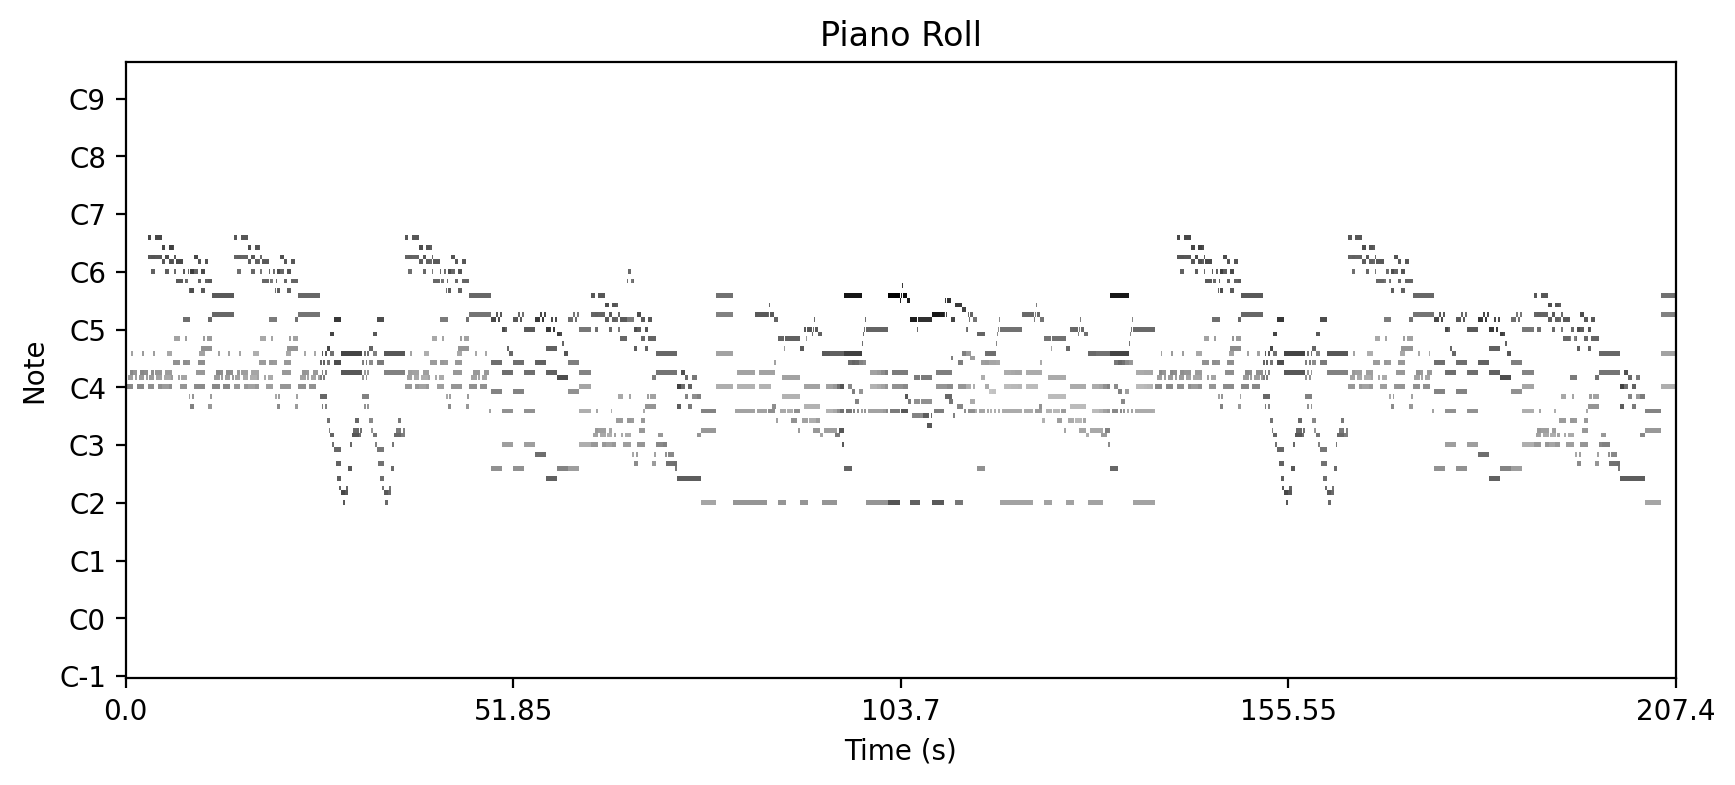

In [40]:
plot_piano_roll('/Users/santiago.perez.gutierrez/Documents/ITAM/Tesina/Dataset Final/gra_esp_2.mid')

### Number of Instruments

In [41]:
# Assuming 'midi_data' is a DataFrame with a column 'num_instruments' representing the number of instruments in each MIDI file
def plot_instrument_distribution(midi_data):
    # Create the countplot
    ax = sns.countplot(x='num_instruments', data=midi_data)
    plt.title('Distribution of Number of Instruments')

    # Adding values on top of the bars
    for p in ax.patches:
        # Get the height of the bar (which represents the data value)
        height = p.get_height()
        # Place a text label above the bar
        ax.text(p.get_x() + p.get_width() / 2., height + 0.1, '%d' % int(height), ha='center')

    plt.show()

In [48]:
midi_data['instruments'].unique()

array(['Acoustic Grand Piano'], dtype=object)

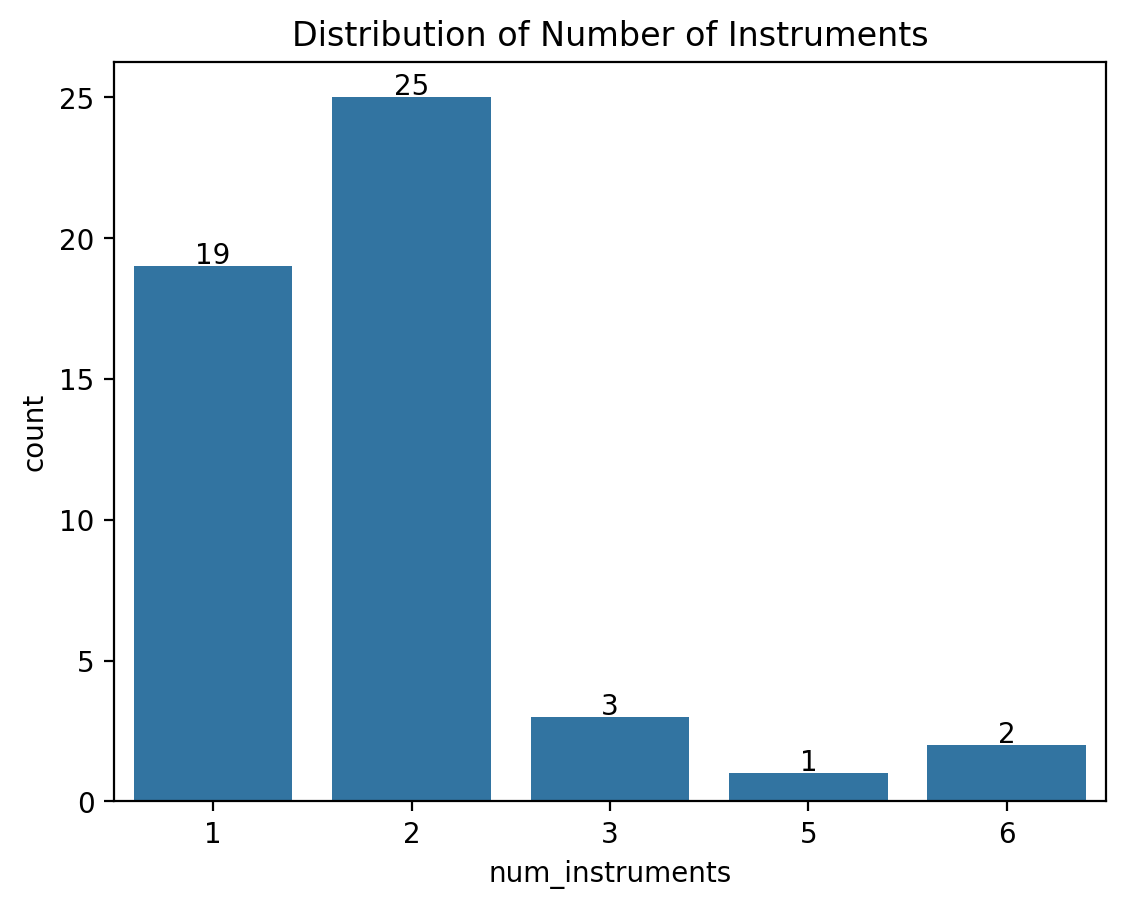

In [42]:
plot_instrument_distribution(midi_data)

Instrument Number Analysis:

As we see in the graph above we contain 6 midi files where there is 3 or more instruments, we should only focus on the ones with two, so that the the model is not affected by other instruments instead of pianos

In [43]:
#Delete rows with 3 or more instruments
midi_data = midi_data[midi_data['num_instruments'] <= 2]

In [44]:
midi_data.head()

,filename,num_instruments,instruments,duration,tempo_changes,key_signatures,time_signatures,avg_pitch,min_pitch,max_pitch,avg_velocity,avg_duration,polyphony,avg_interval,pitch_classes,main_key,chords,notes
2,muss_3.mid,2,Acoustic Grand Piano,89.440365,310,2,8,67.607626,27,90,47.820418,0.355700,9.089856,0.106152,"[15, 86, 32, 140, 32, 65, 151, 28, 88, 25, 30,...",B major,"71.67, 82.90.75, 87.83.78, 30.42, 52.40, 65.61...","(68,0.00,0.64,77) (56,0.00,0.64,65) (54,0.64,1..."
3,muss_1.mid,2,Acoustic Grand Piano,210.571309,1036,2,21,56.749396,27,94,61.642512,0.438788,7.864319,0.126381,"[122, 47, 130, 245, 58, 232, 106, 127, 77, 144...",E- major,"48.36, 81.69.72, 57.45, 30.42, 58.70.65, 66.70...","(67,0.00,0.63,90) (65,0.60,1.22,85) (70,1.20,1..."
4,mendel_op19_3.mid,2,Acoustic Grand Piano,137.633716,430,1,1,65.702386,28,97,57.596902,0.186539,17.357665,0.057595,"[11, 436, 127, 73, 516, 5, 249, 1, 214, 448, 3...",A major,"48.36, 52.62.56, 69.64, 57.50.59.54, 61.54, 71...","(64,0.57,1.32,70) (61,1.32,1.41,69) (64,1.41,1..."
5,gra_esp_4.mid,2,Acoustic Grand Piano,282.377630,759,3,7,63.857296,31,91,45.261358,0.538972,6.625879,0.150154,"[249, 7, 482, 31, 113, 51, 62, 387, 1, 183, 65...",G major,"50.54, 62.70.74, 84.84, 67.57.66, 50.57, 74.70...","(62,0.00,0.73,77) (59,0.00,0.73,64) (86,0.73,1..."
6,mendel_op19_2.mid,2,Acoustic Grand Piano,168.378761,175,1,1,60.318442,33,82,38.747995,0.515975,5.184739,0.192126,"[114, 3, 88, 18, 194, 69, 13, 44, 49, 158, 9, ...",A minor,"64.60, 71.74, 67.70, 77.71, 71.77, 78.69, 76.6...","(76,0.69,1.30,65) (74,1.30,1.91,72) (72,1.91,2..."


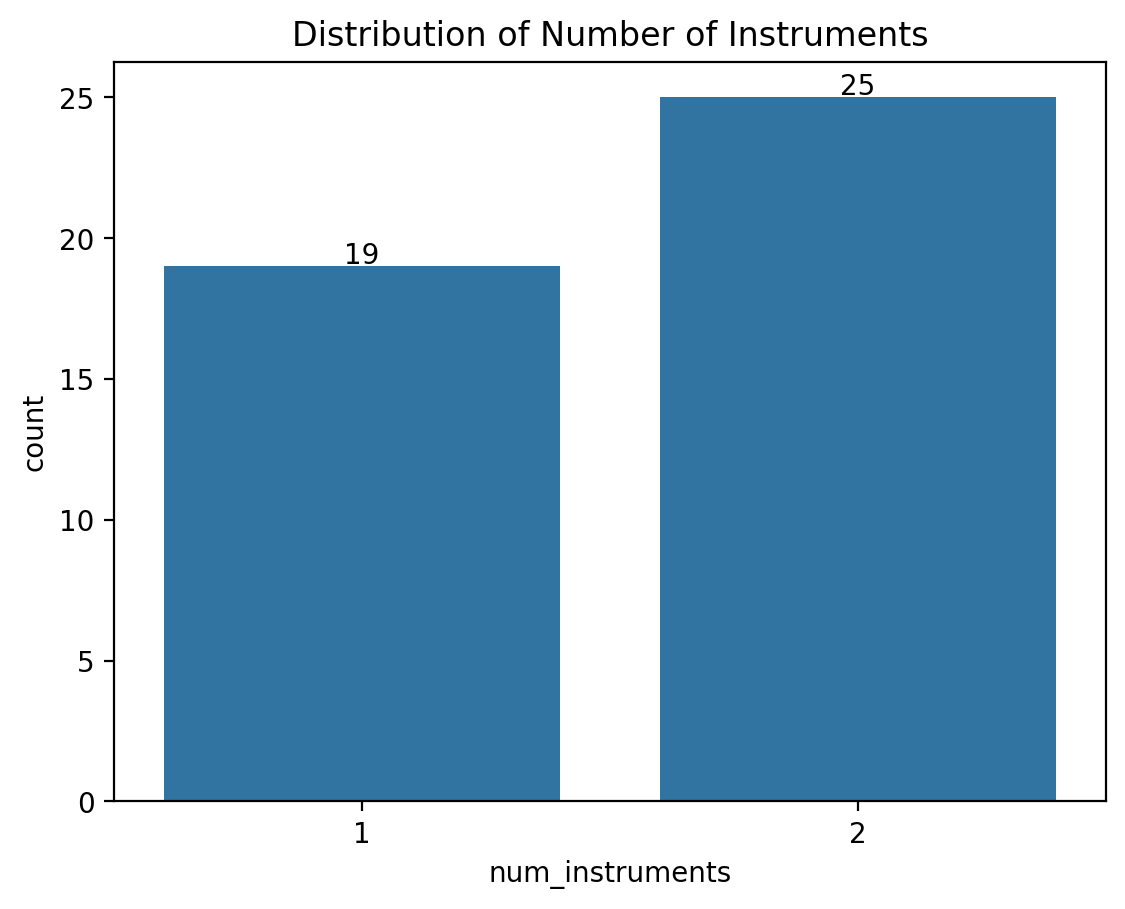

In [45]:
plot_instrument_distribution(midi_data)

In [46]:
#count how many different instruments are in the DF
midi_data['instruments'].nunique()

1

In [47]:
#what are the different instruments
midi_data['instruments'].unique()

array(['Acoustic Grand Piano'], dtype=object)

Now we have songs that contains only 2 or 1 instrument all of them being Acoustic Grand Piano

### Duration of the MIDI files

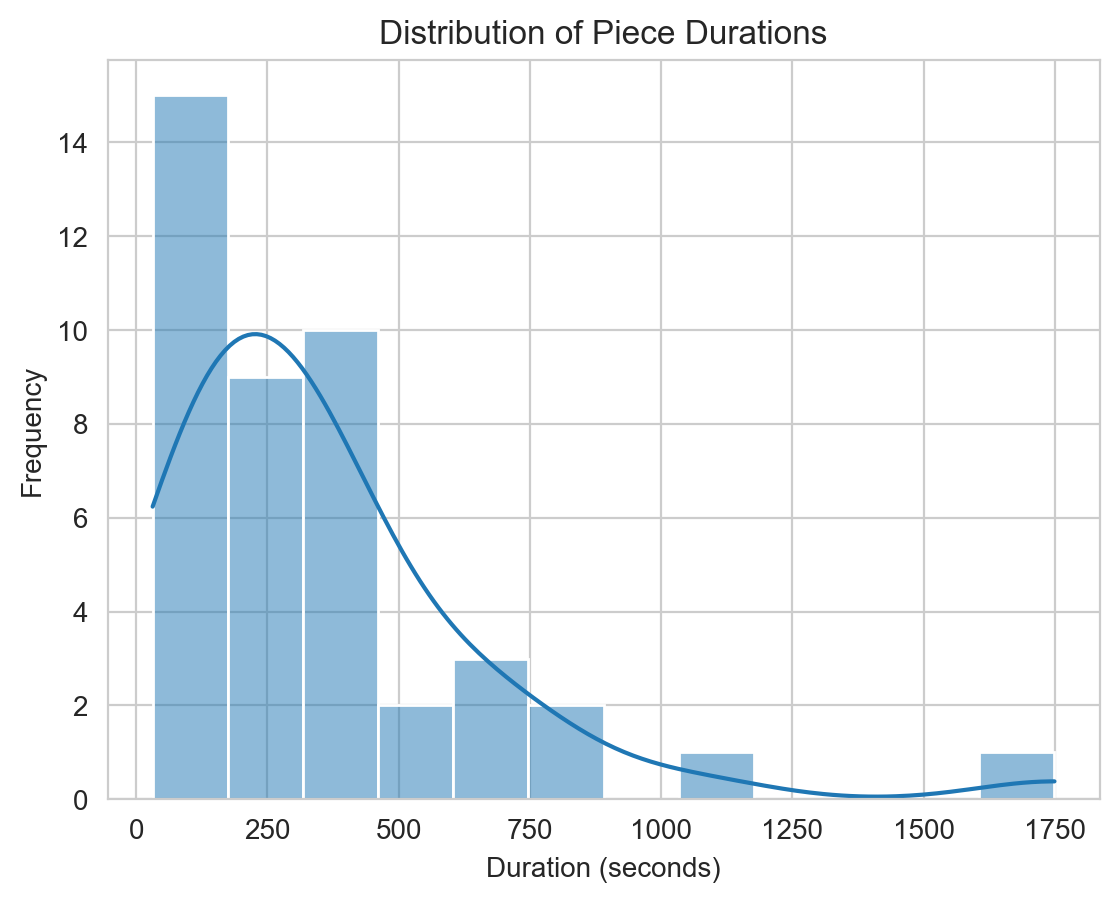

In [68]:
# Histogram of durations
sns.histplot(midi_data['duration'], kde=True)
plt.title('Distribution of Piece Durations')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.show()

From the graph, we can infer several things that are useful for training an RNN for music generation:

1. **Most Common Durations**: The majority of pieces are concentrated in the lower range of durations, particularly between 0 to 500 seconds. Shorter pieces are more prevalent in our dataset.

2. **Duration Variability**: There are fewer pieces with longer durations, but they do exist, indicating there is some variability in the dataset. This is important for your model to learn if you want it to generate pieces with varying lengths. There are a few pieces with much longer durations, around 3000 seconds and above. These could be outliers, and you should decide whether to include them in your training set as they might skew the average duration of generated pieces if not properly accounted for.


In [69]:
#DELETE OUTLIERS
midi_data = midi_data[midi_data['duration'] < 1000]

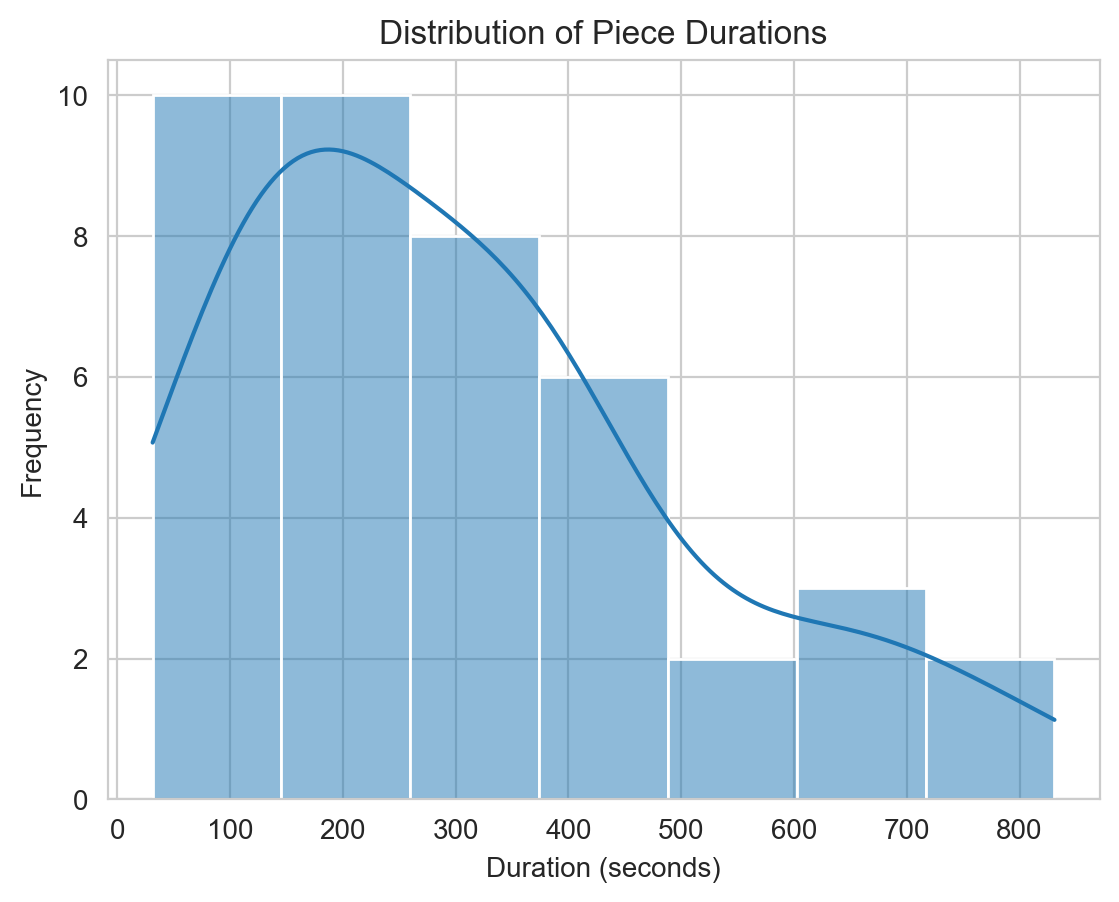

In [70]:
# Histogram of durations
sns.histplot(midi_data['duration'], kde=True)
plt.title('Distribution of Piece Durations')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.show()

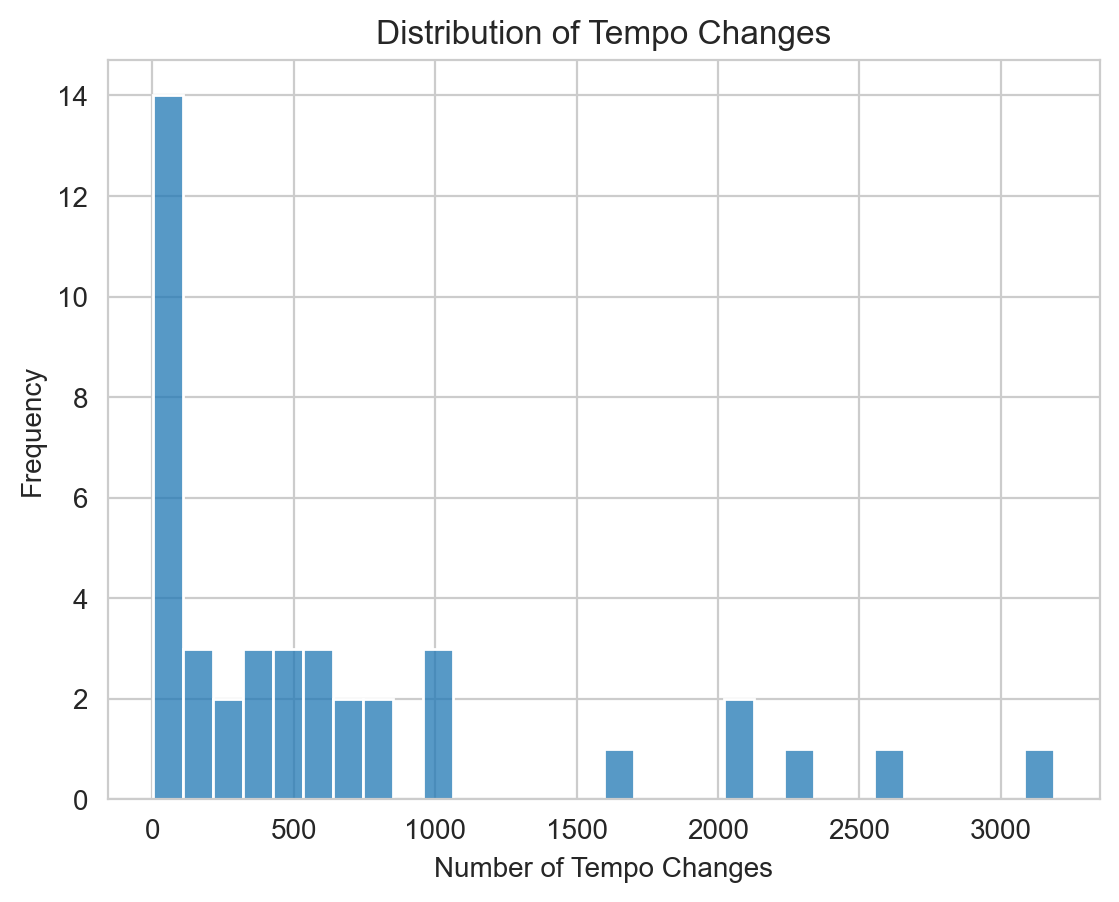

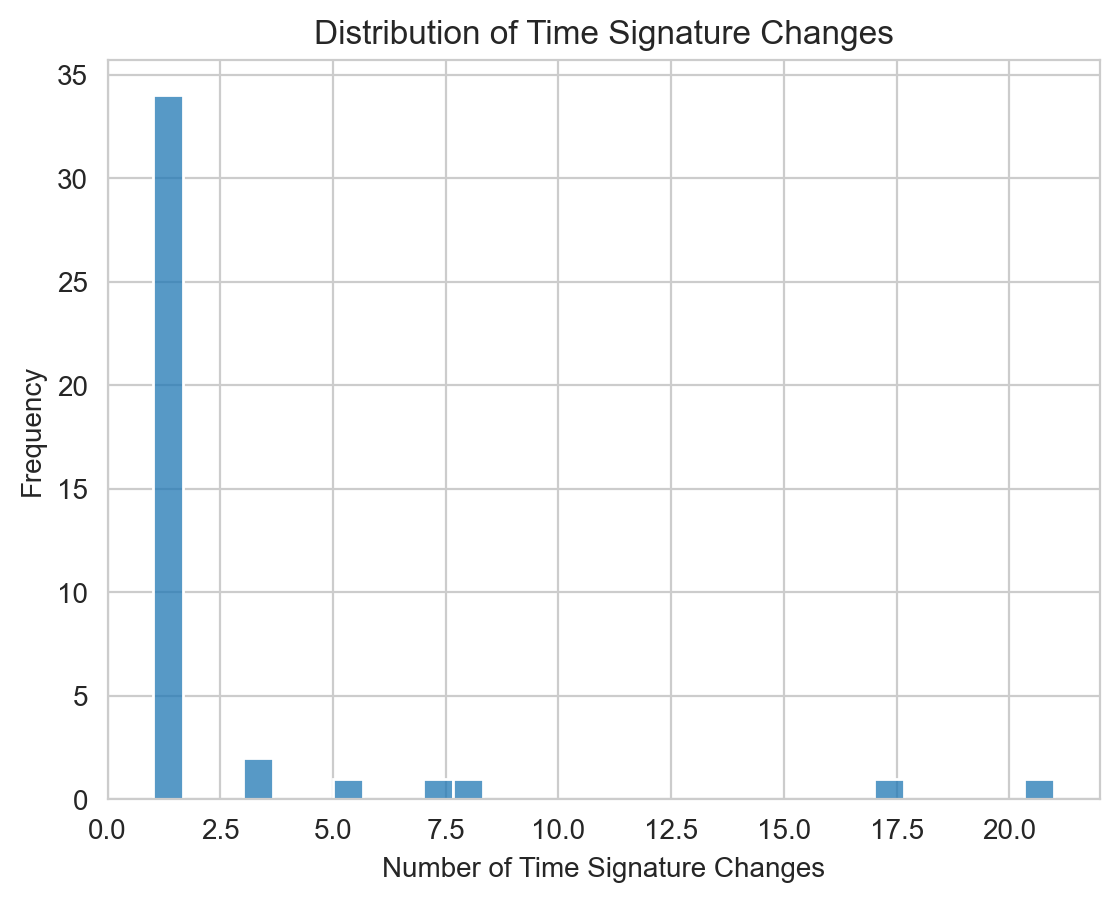

In [71]:
# Histogram of tempo changes
sns.histplot(midi_data['tempo_changes'], bins=30)
plt.title('Distribution of Tempo Changes')
plt.xlabel('Number of Tempo Changes')
plt.ylabel('Frequency')
plt.show()

# Histogram of time signature changes
sns.histplot(midi_data['time_signatures'], bins=30)
plt.title('Distribution of Time Signature Changes')
plt.xlabel('Number of Time Signature Changes')
plt.ylabel('Frequency')
plt.show()

### Distribution of Tempo Changes

1. **Sparse Tempo Changes**: Most pieces have few or no tempo changes, with a large frequency at 0. This indicates that tempo tends to remain constant throughout most pieces.
2. **Few Variations**: There are some pieces with a higher number of tempo changes, but these are less common. This could suggest that these pieces are more complex or have more movement and variation in terms of speed.
3. **Outliers**: Pieces with an extremely high number of tempo changes (e.g., over 2500) are rare. These might be specific types of compositions or outliers that you may want to examine further.

### Distribution of Time Signature Changes

1. **Stable Time Signatures**: Similar to tempo, most pieces have a stable time signature with no changes throughout the piece, which is indicated by the high frequency at 0.
2. **Occasional Variability**: A small number of pieces do have time signature changes, but they are not common. This might reflect specific genres or compositional styles where time signature changes are a characteristic feature.
3. **Rare Complexity**: Very few pieces have a large number of time signature changes, suggesting that such complexity is not common in the dataset.


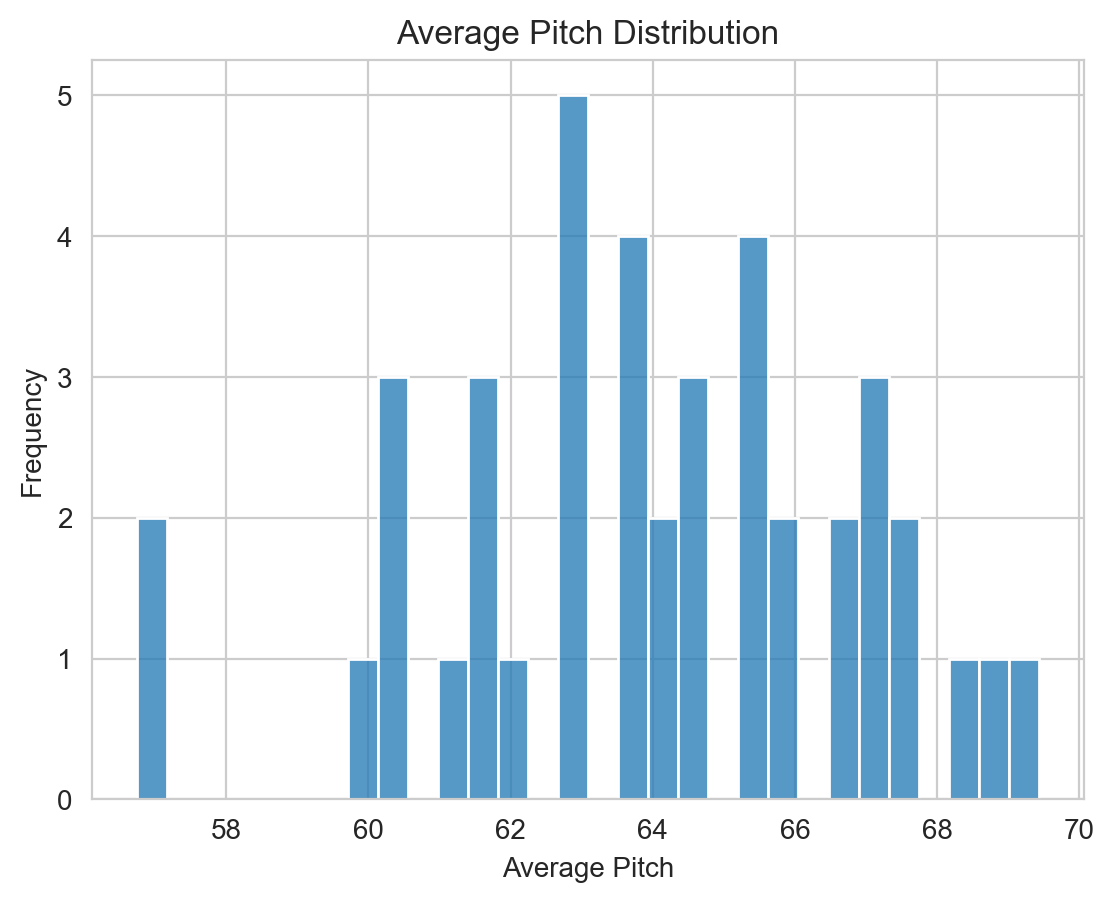

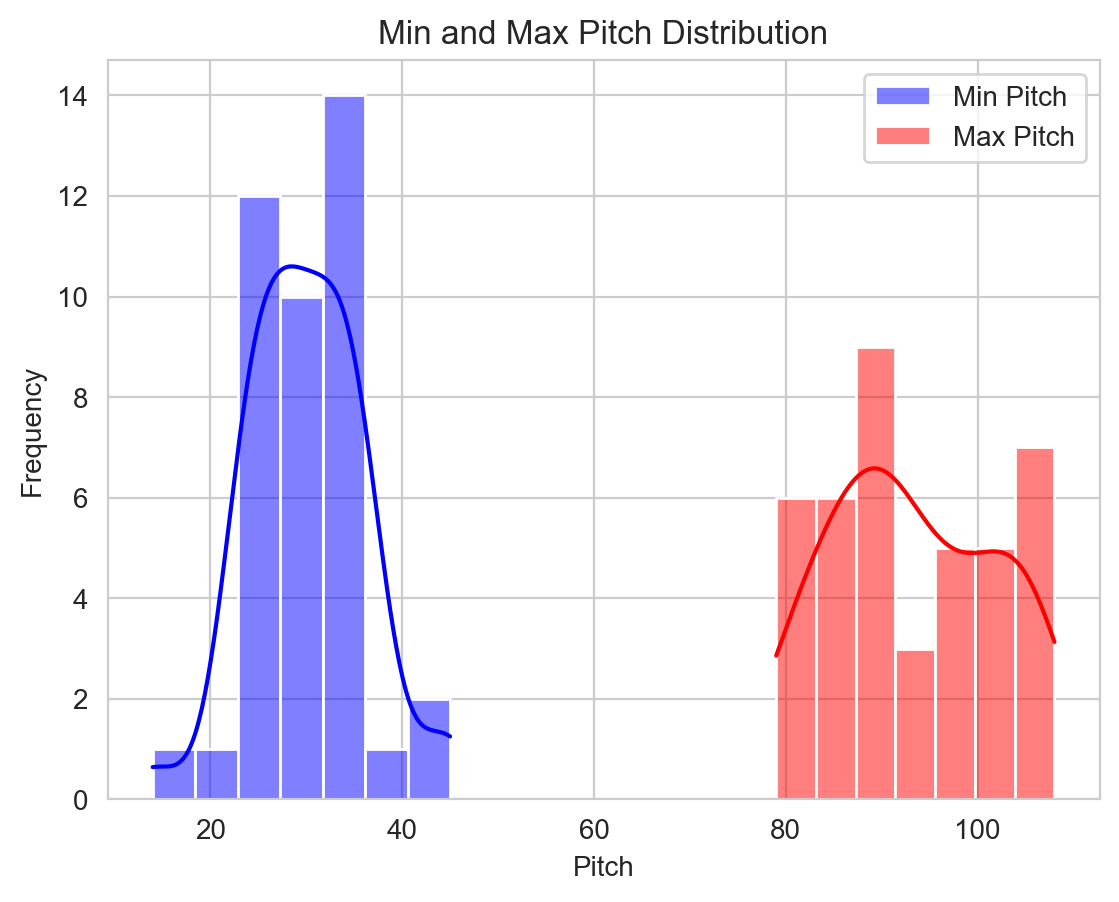

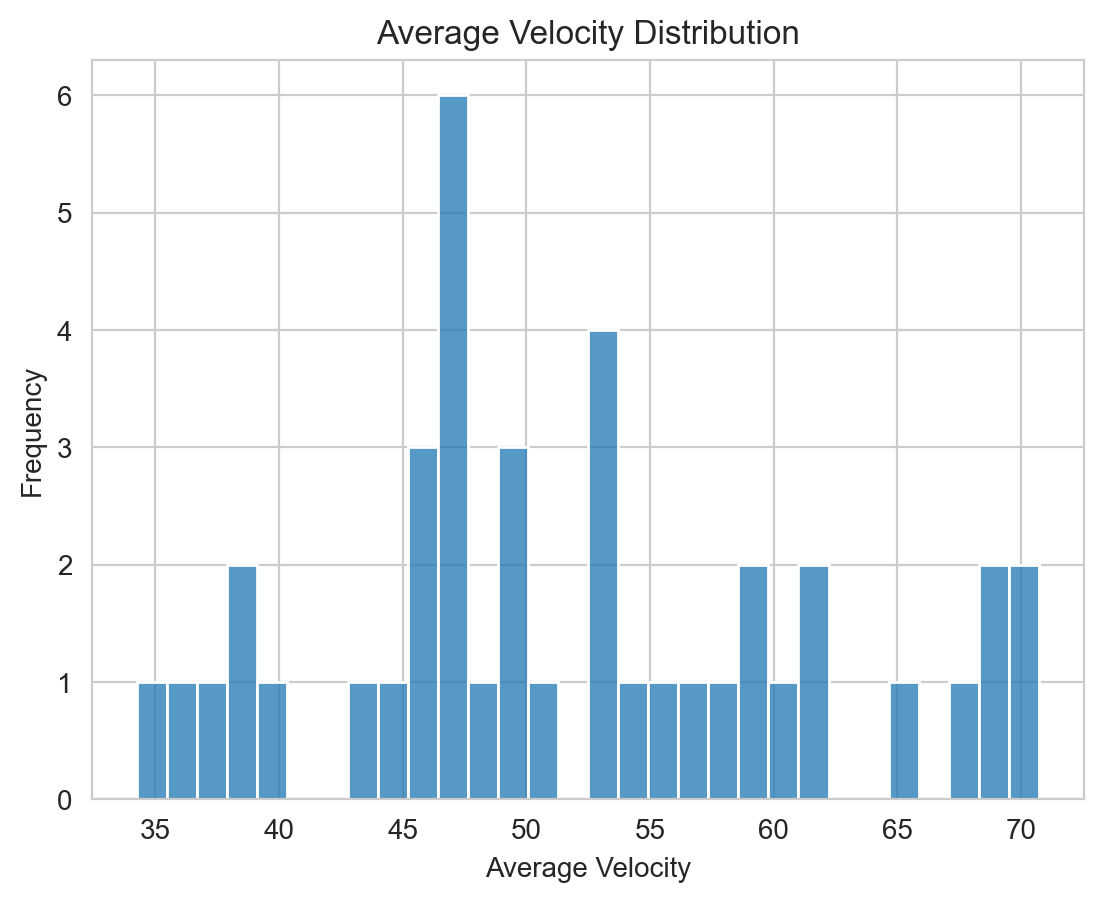

In [72]:
# Average Pitch Distribution
sns.histplot(midi_data['avg_pitch'], bins=30)
plt.title('Average Pitch Distribution')
plt.xlabel('Average Pitch')
plt.ylabel('Frequency')
plt.show()

# Min and Max Pitch Distribution
sns.histplot(midi_data['min_pitch'], color='blue', label='Min Pitch', kde=True)
sns.histplot(midi_data['max_pitch'], color='red', label='Max Pitch', kde=True)
plt.legend()
plt.title('Min and Max Pitch Distribution')
plt.xlabel('Pitch')
plt.ylabel('Frequency')
plt.show()

# Average Velocity Distribution
sns.histplot(midi_data['avg_velocity'], bins=30)
plt.title('Average Velocity Distribution')
plt.xlabel('Average Velocity')
plt.ylabel('Frequency')
plt.show()


### Average Pitch Distribution

- **Central Tendency**: The distribution appears to be somewhat uniform with multiple peaks, suggesting there isn't a single average pitch that dominates your dataset.
- **Range**: The average pitch values are spread out between 58 and 70, which corresponds to around the range of Bb1 to C#5 in scientific pitch notation. This suggests a mid-range concentration of pitches for your average values.

### Min and Max Pitch Distribution

- **Min Pitch**: The minimum pitch values are concentrated around the lower range (20-40), which suggests that most pieces have their lowest notes within the bass or lower tenor range.
- **Max Pitch**: The maximum pitch values are more spread out but have concentrations at both the lower and higher ranges. This indicates a variety in the highest notes across pieces, from mid-range to soprano pitches.

### Average Velocity Distribution

- **Variability in Dynamics**: The histogram shows a spread of average velocity values with several peaks. This implies variability in the dynamics across pieces, with no single dynamic level being overly dominant.
- **Mid-Range Dynamics**: Most pieces have an average velocity (dynamics) around the mid-range, indicating that neither very soft nor very loud dynamics overly dominate the dataset.

### Implications for RNN Music Generation:

- **Pitch Representation**: The RNN will need to learn a range of pitches that reflect the spread seen in the average pitch distribution. It should not bias towards any specific pitch range.
  
- **Dynamic Range**: The model should be able to generate notes with a range of dynamics, as indicated by the spread in the average velocity distribution.
  
- **Note Range**: The RNN should be capable of generating music that reflects the min and max pitch distributions, ensuring that compositions have realistic and varied pitch ranges.

- **Melodic Contour**: Given the spread of average pitches, the model should be trained to understand the contour of melodies which may not stick to a narrow pitch range.
  
- **Expressiveness**: The dynamics (velocity) of the music are an important part of its expressiveness. The model should learn to vary dynamics to reflect the diversity found in the dataset.

By ensuring your RNN considers the range and diversity of pitch and dynamics represented in your dataset, the generated music will likely be more varied and interesting, offering a more authentic and engaging listening experience.

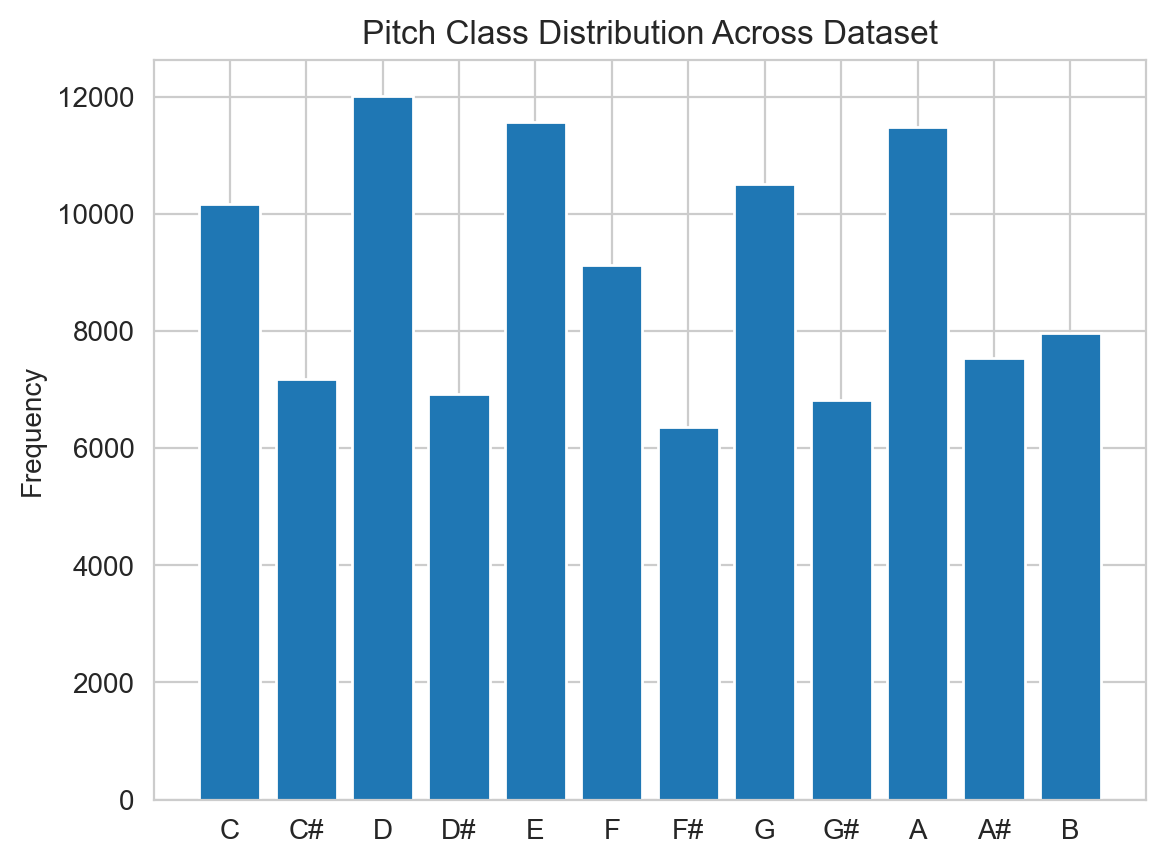

In [73]:
# Aggregate pitch class distributions from all files
total_pitch_classes = [0] * 12
for pc in midi_data['pitch_classes']:
    for i in range(12):
        total_pitch_classes[i] += pc[i]

# Plotting
fig, ax = plt.subplots()
ax.bar(range(12), total_pitch_classes)
ax.set_xticks(range(12))
ax.set_xticklabels(['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B'])
ax.set_title('Pitch Class Distribution Across Dataset')
ax.set_ylabel('Frequency')
plt.show()


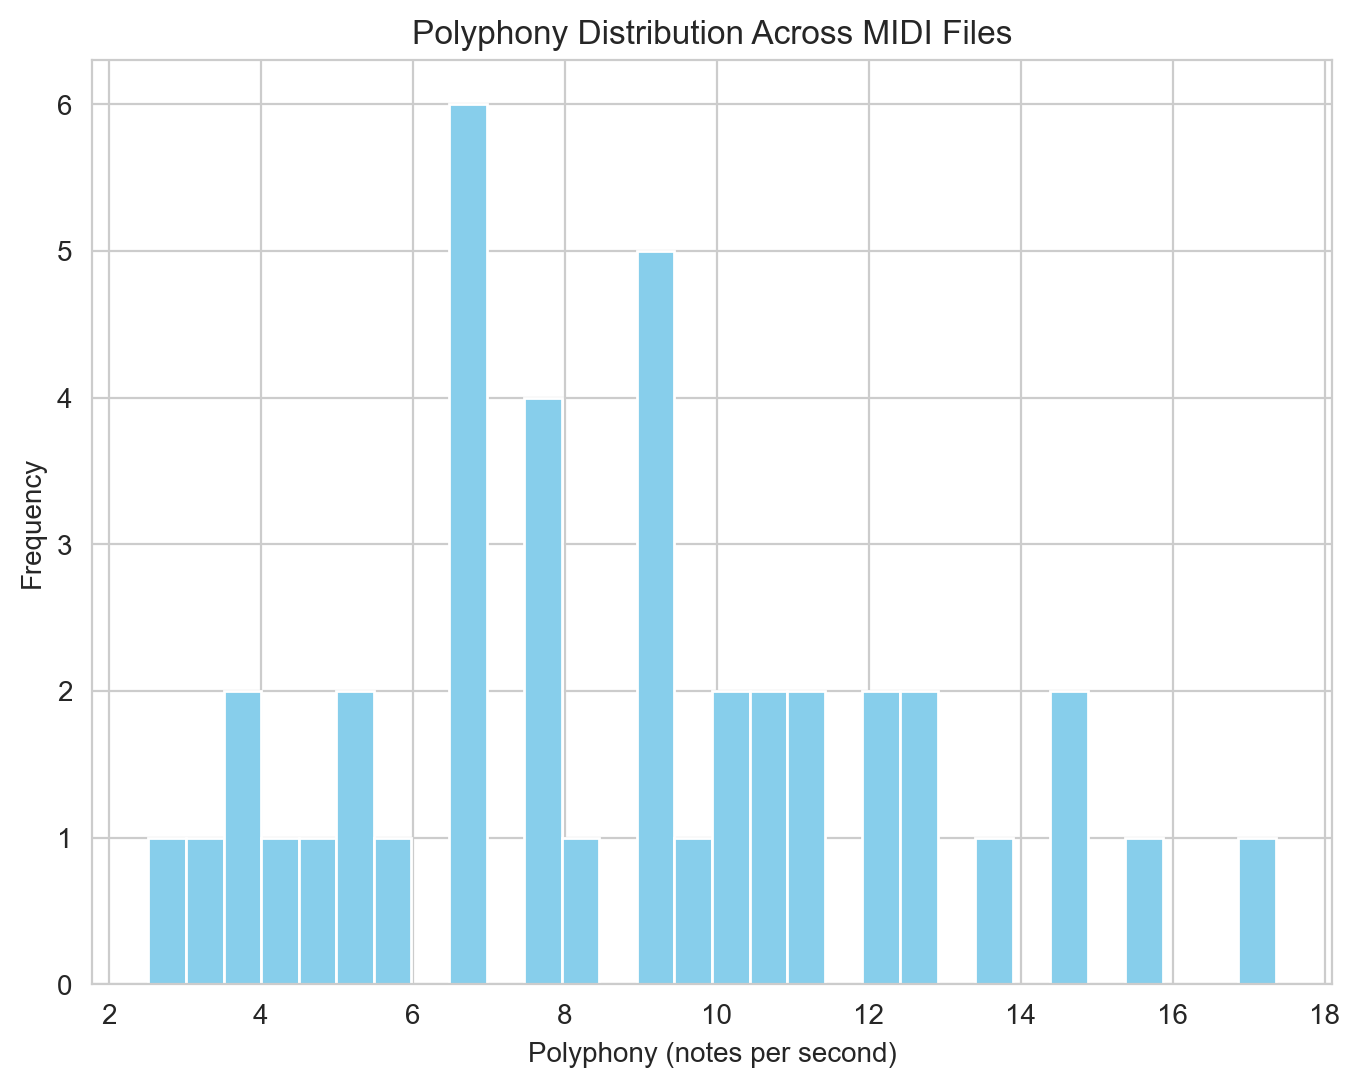

In [74]:
# Plotting the distribution of polyphony
plt.figure(figsize=(8, 6))
plt.hist(midi_data['polyphony'], bins=30, color='skyblue')
plt.title('Polyphony Distribution Across MIDI Files')
plt.xlabel('Polyphony (notes per second)')
plt.ylabel('Frequency')
plt.show()


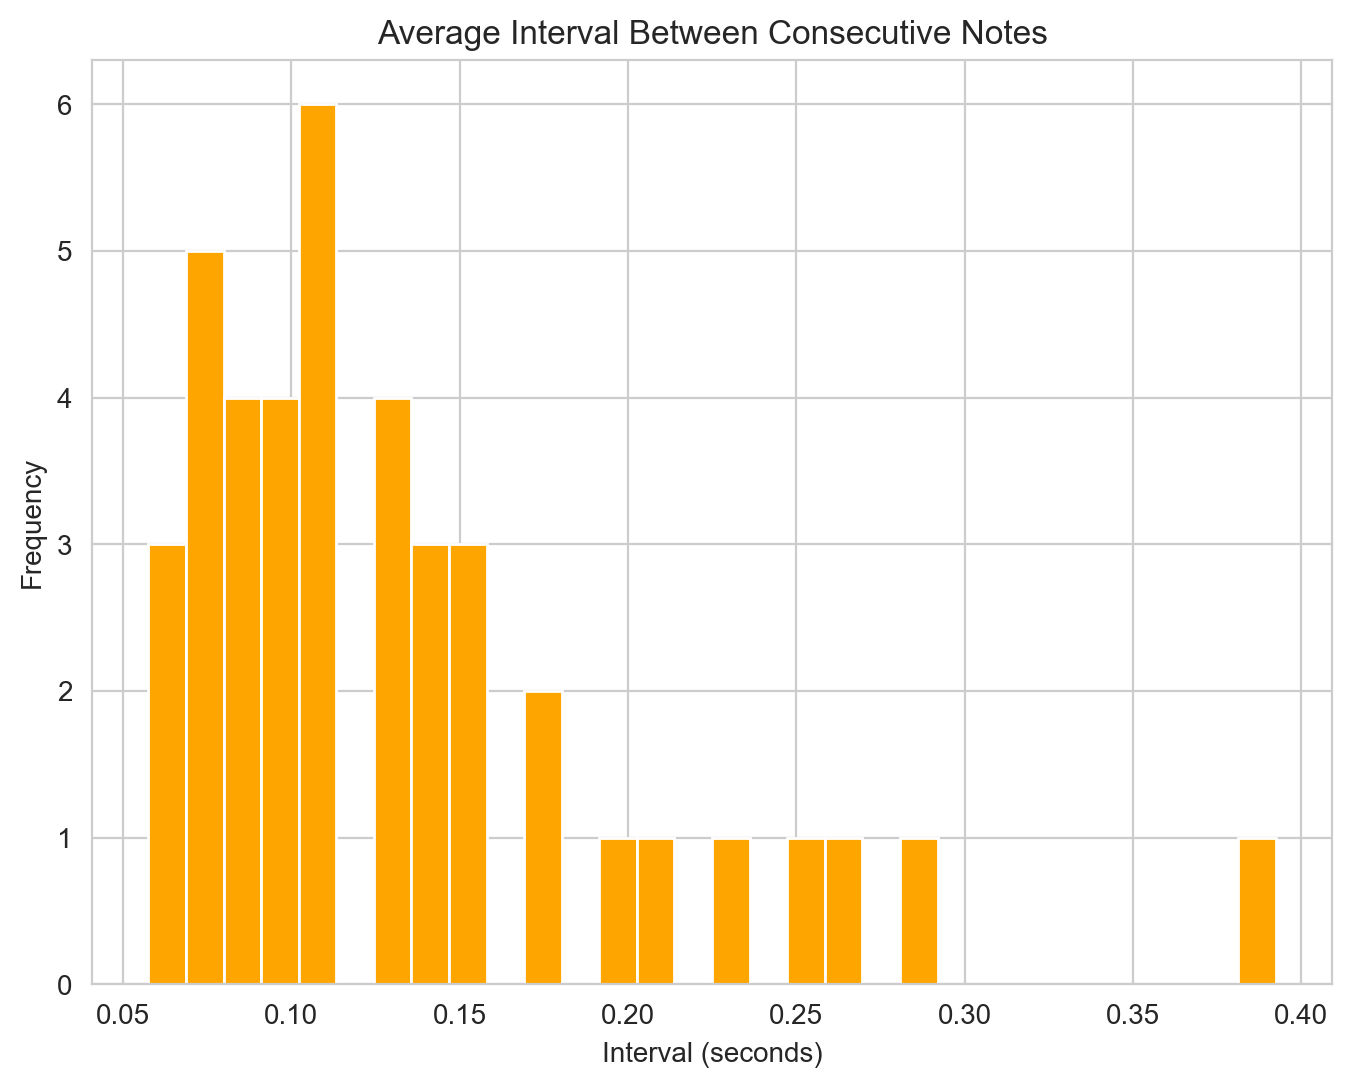

In [75]:
# Plotting the average interval between consecutive notes
plt.figure(figsize=(8, 6))
plt.hist(midi_data['avg_interval'], bins=30, color='orange')
plt.title('Average Interval Between Consecutive Notes')
plt.xlabel('Interval (seconds)')
plt.ylabel('Frequency')
plt.show()


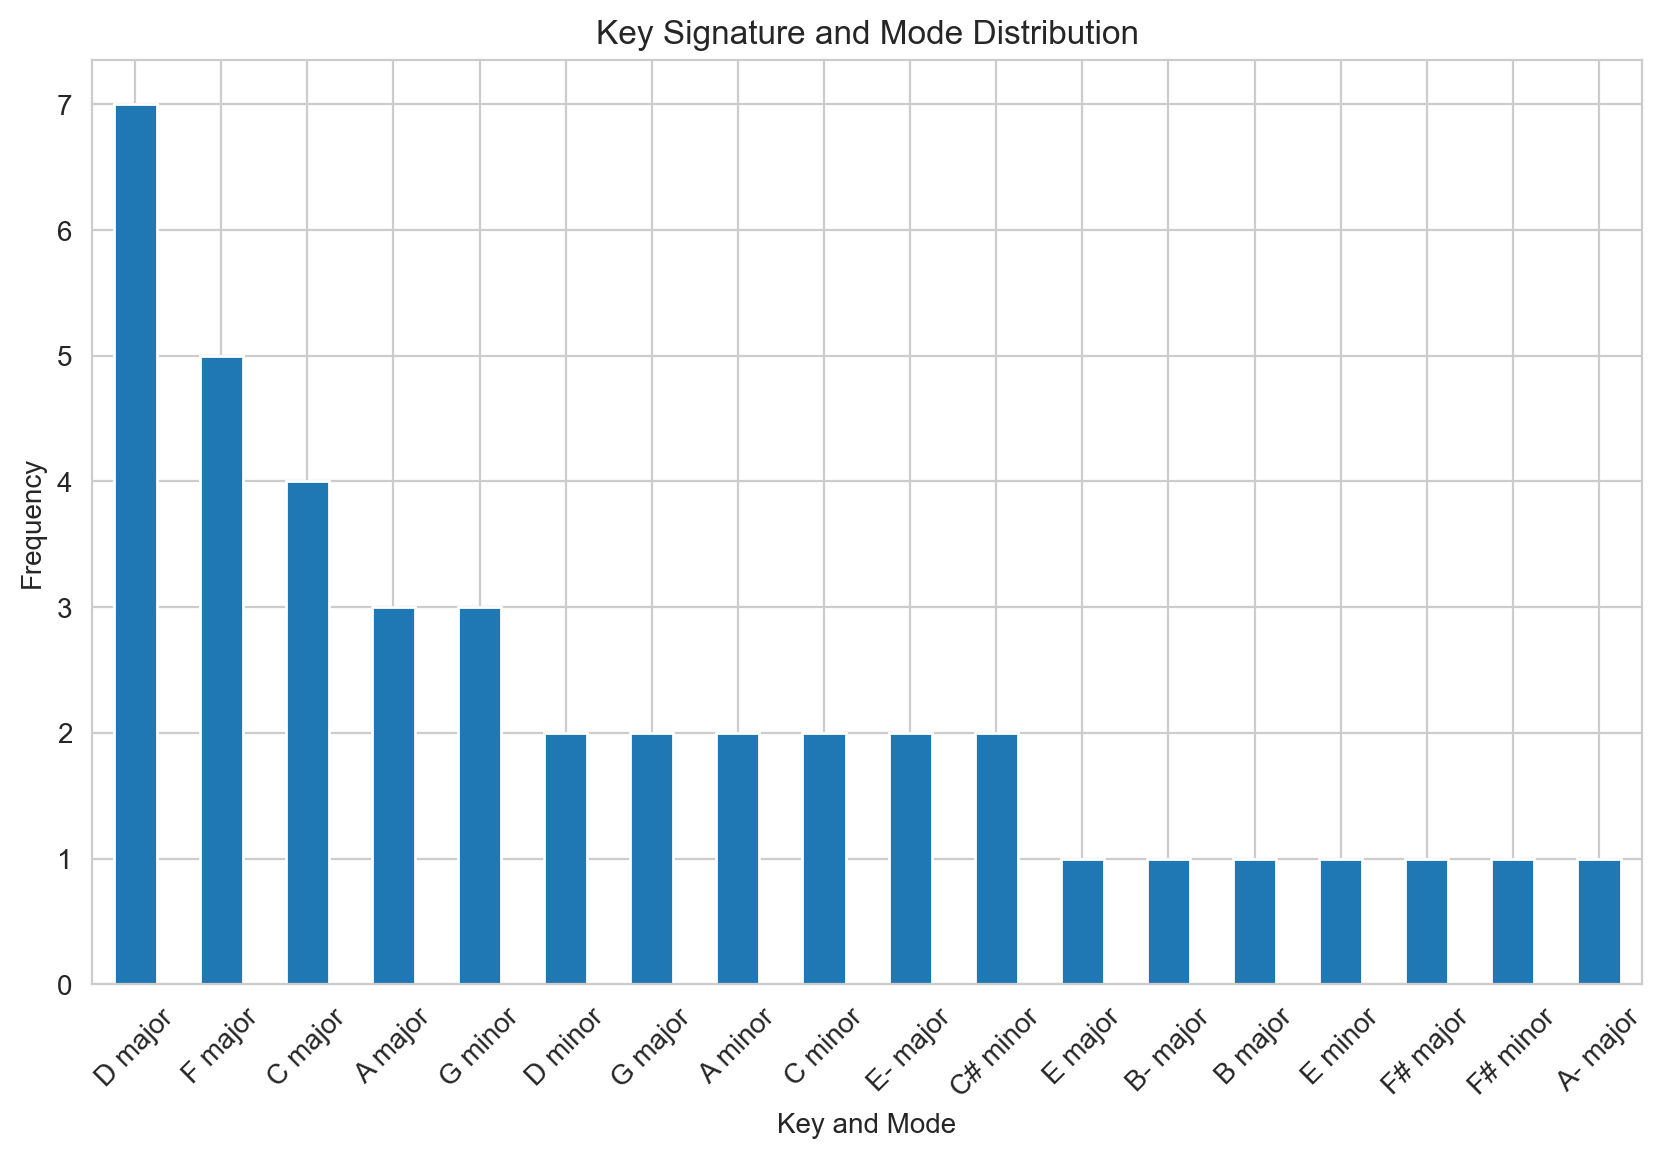

In [76]:
# Extracting key signatures and modes
keys = midi_data['main_key'].value_counts()

# Plotting
keys.plot(kind='bar', figsize=(10, 6))
plt.title('Key Signature and Mode Distribution')
plt.xlabel('Key and Mode')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


One of the main objectives of our model is to be able to generate a broad spectrum of music. So better for the model to have a broad number of keys and modes

In [57]:
# Extracting key signatures and modes
keys = midi_data['main_key'].value_counts()

print(keys)
print(sum(keys))


main_key
D major     7
F major     6
C major     4
G minor     3
A major     3
A- major    3
C# minor    2
E- major    2
D minor     2
C minor     2
A minor     2
G major     2
F# minor    1
F# major    1
E minor     1
E major     1
B- major    1
B major     1
Name: count, dtype: int64
44


In [59]:
from collections import Counter

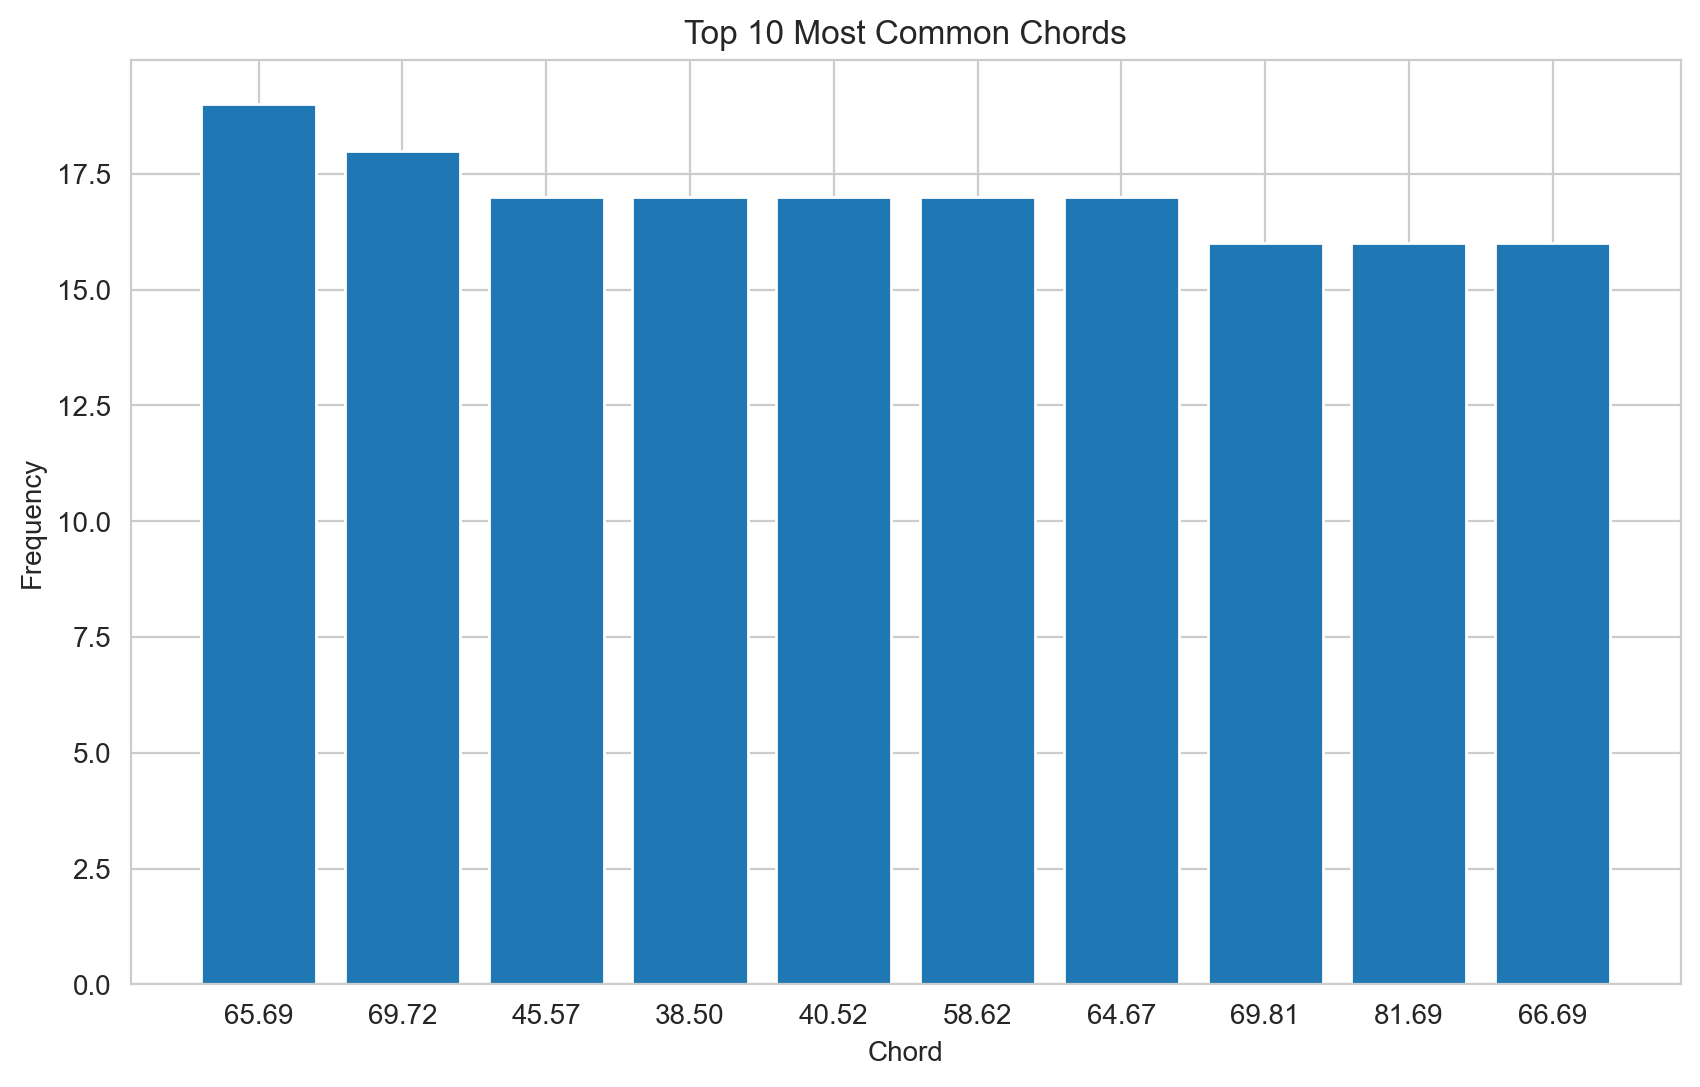

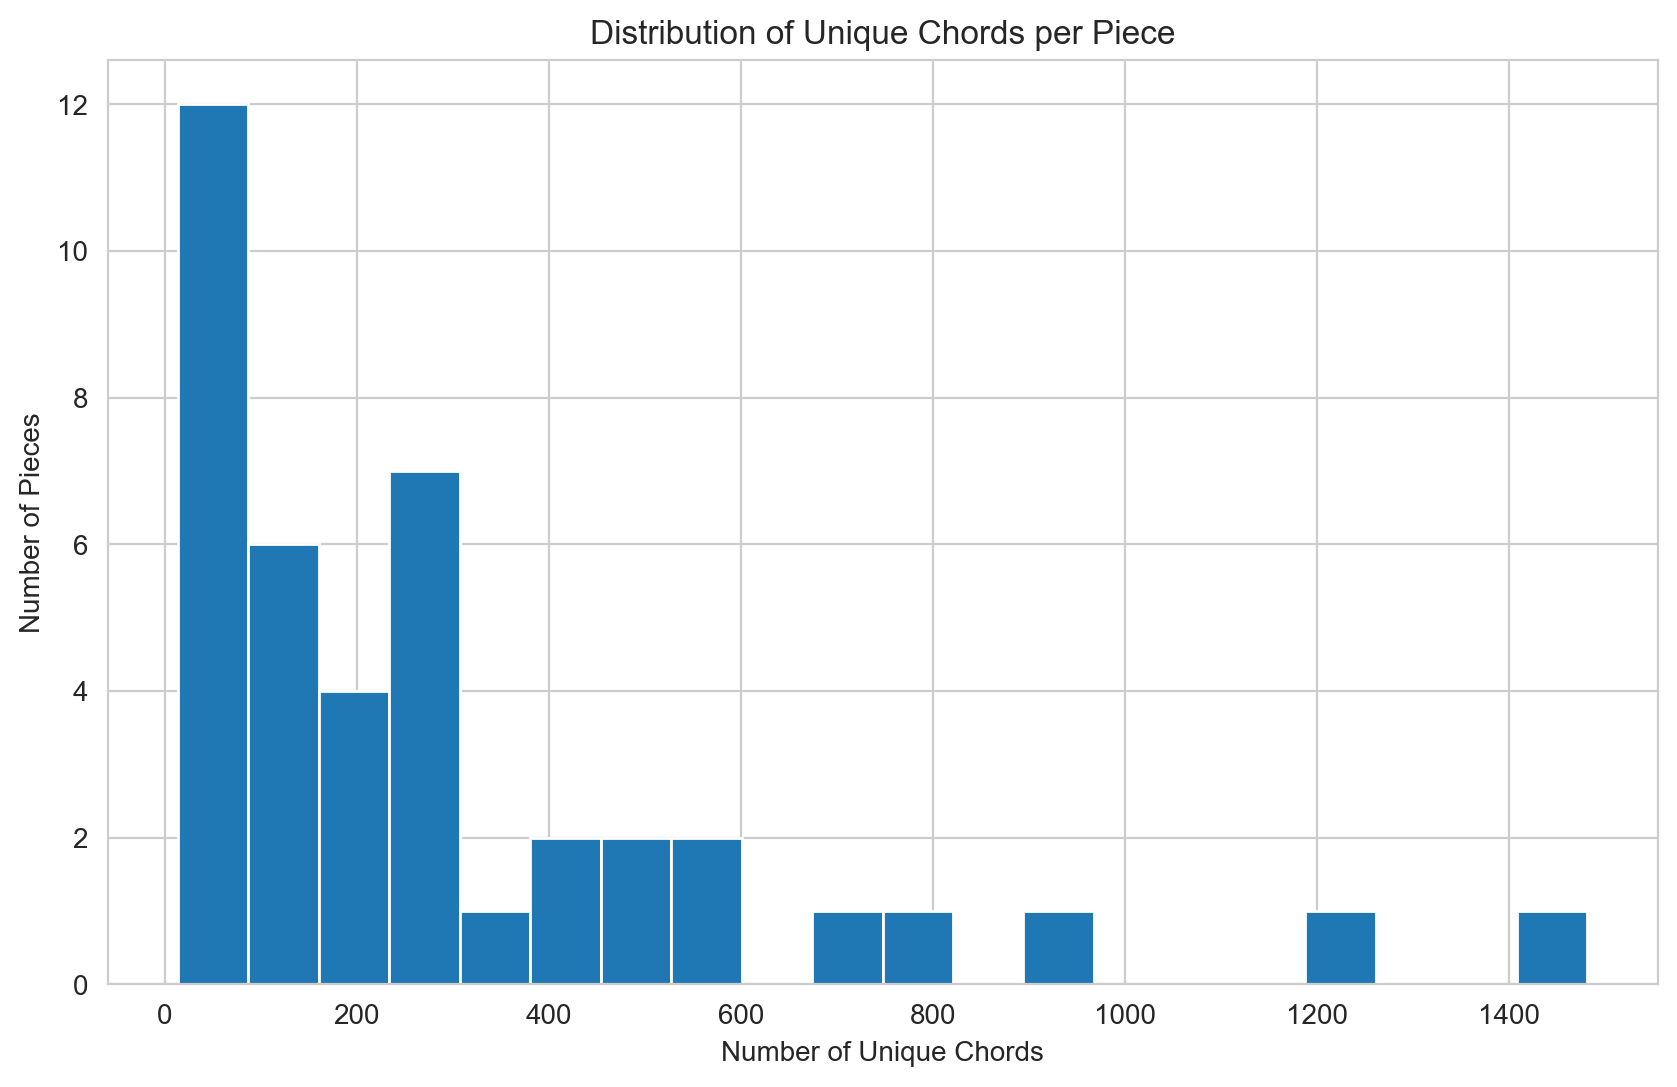

In [77]:

# Assuming `chords` column contains strings of unique chords separated by commas
midi_data['chord_list'] = midi_data['chords'].apply(lambda x: x.split(', '))

# Chord Frequency Distribution
all_chords = [chord for sublist in midi_data['chord_list'] for chord in sublist]
chord_counts = Counter(all_chords)
most_common_chords = chord_counts.most_common(10)  # Adjust as needed

# Plotting the most common chords
plt.figure(figsize=(10, 6))
plt.bar([chord[0] for chord in most_common_chords], [chord[1] for chord in most_common_chords])
plt.xlabel('Chord')
plt.ylabel('Frequency')
plt.title('Top 10 Most Common Chords')
plt.show()

# Chord Diversity per Piece
midi_data['unique_chords_count'] = midi_data['chord_list'].apply(len)
plt.figure(figsize=(10, 6))
midi_data['unique_chords_count'].hist(bins=20)
plt.xlabel('Number of Unique Chords')
plt.ylabel('Number of Pieces')
plt.title('Distribution of Unique Chords per Piece')
plt.show()

In [61]:
# Set the style for seaborn plots
sns.set_style("whitegrid")

def plot_descriptive_statistics(data):
    desc_stats = data.describe().transpose()
    print(desc_stats[['mean', 'std', '50%', 'min', 'max']])
    
    # Conclusions can be drawn by observing the mean, standard deviation, and median values to understand the central tendency
    # and dispersion of the data. Min and max values help id

In [62]:
plot_descriptive_statistics(midi_data)

                           mean          std         50%        min  \
num_instruments        1.568182     0.501056    2.000000   1.000000   
duration             431.959700   600.265469  291.845065  31.358879   
tempo_changes        569.022727   789.491991  328.000000   1.000000   
key_signatures         1.318182     1.360108    1.000000   0.000000   
time_signatures        2.295455     4.009173    1.000000   1.000000   
avg_pitch             64.038713     2.943229   64.274086  56.749396   
min_pitch             29.886364     5.879471   29.000000  14.000000   
max_pitch             93.590909     8.548951   92.000000  79.000000   
avg_velocity          52.678062     9.999712   51.572440  34.263727   
avg_duration           0.358876     0.195388    0.323556   0.084478   
polyphony              8.897150     3.497925    9.091707   2.522720   
avg_interval           0.132558     0.067403    0.107747   0.057595   
unique_chords_count  536.181818  1182.152772  235.500000  14.000000   

     

In [65]:
def plot_correlations(data):
    
    corr = data.select_dtypes(include=['float64', 'int64']).corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
    plt.title('Correlation Matrix')

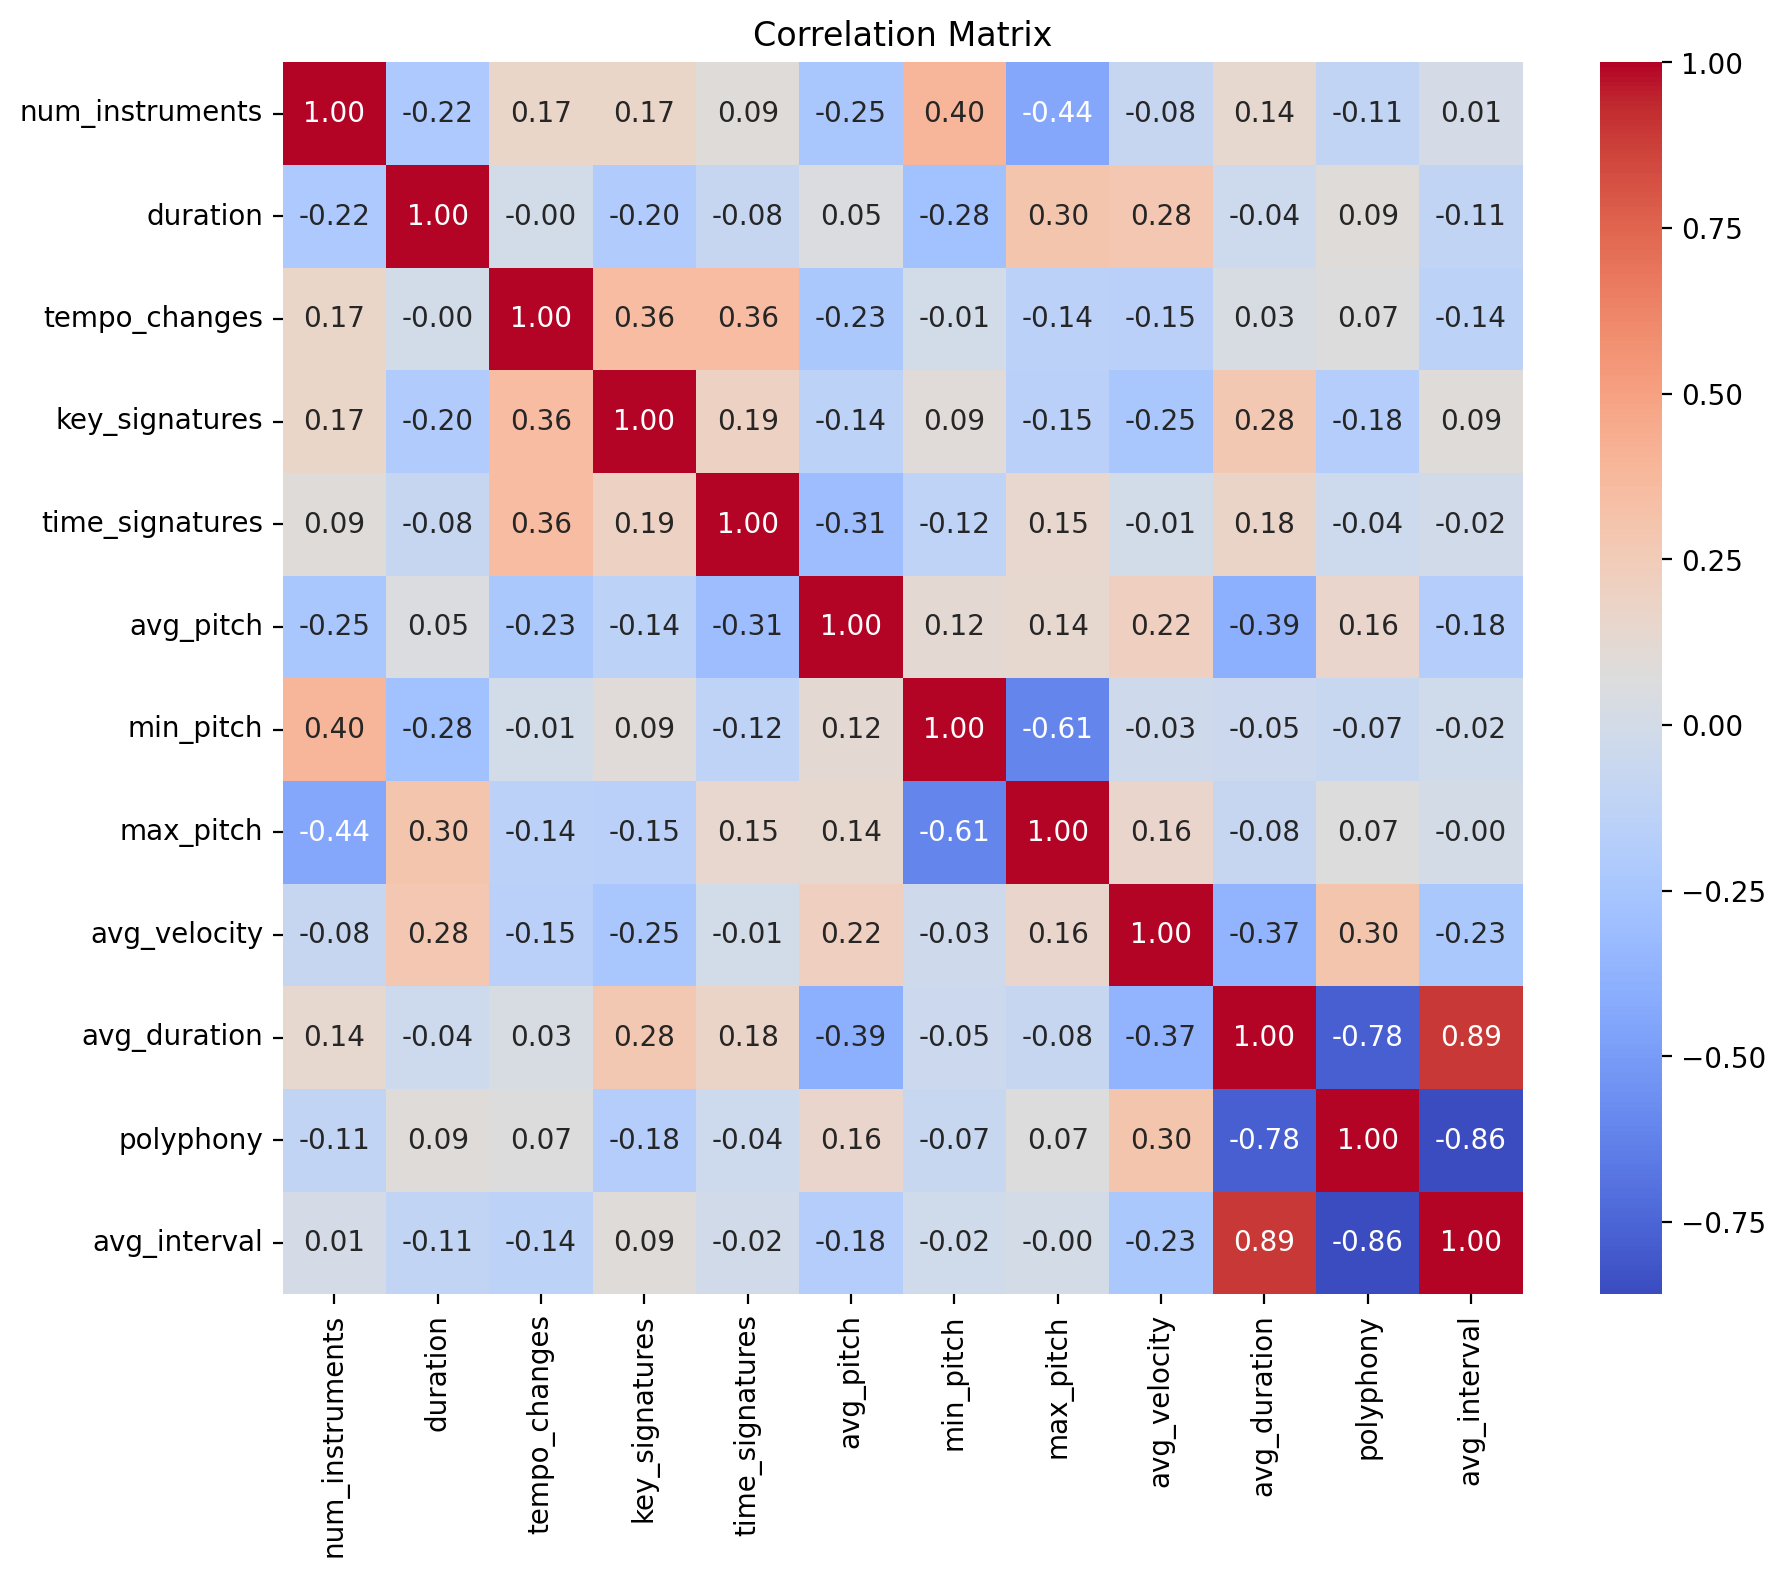

In [17]:
plot_correlations(midi_data)

Based on the correlation matrix provided, here are some conclusions we can draw:

1. **Negative Correlations**:
    - `num_instruments` and `avg_pitch`: A slight negative correlation (-0.25) suggests that pieces with more instruments tend to have a lower average pitch.
    - `min_pitch` and `max_pitch`: There is a strong negative correlation (-0.61) indicating that pieces with a higher minimum pitch tend to have a lower maximum pitch, and vice versa.
    - `avg_duration` and `polyphony`: A very strong negative correlation (-0.78) suggests that pieces with longer average note durations tend to have less polyphony, meaning fewer simultaneous notes.
    - `avg_duration` and `avg_interval`: Also a very strong negative correlation (-0.86) indicating that longer average note durations correspond with shorter intervals between notes.

2. **Positive Correlations**:
    - `duration` and `tempo_changes`: There is no significant correlation, indicating that the length of a piece does not necessarily correspond with the number of tempo changes.
    - `tempo_changes` and `key_signatures`, and `tempo_changes` and `time_signatures`: Moderate positive correlations (0.36 for both) suggest that pieces with more tempo changes also tend to have more key and time signature changes.
    - `avg_velocity` and `polyphony`: A moderate positive correlation (0.30) implies that pieces with louder notes (higher velocity) tend to have more polyphony.
    - `avg_duration` and `avg_interval`: A very strong positive correlation (0.89) suggests that pieces with longer average note durations also tend to have longer intervals between notes.

3. **No Significant Correlation**:
    - Several pairs of features, such as `num_instruments` and `duration` (-0.22), do not show a strong correlation, indicating no significant linear relationship between these variables.

The strong negative correlation between `avg_duration` and `polyphony` could suggest that when designing a model for music generation, if the goal is to produce pieces with rich polyphony, it might be beneficial to favor shorter note durations. The lack of correlation between `num_instruments` and `duration` might imply that the complexity of the piece in terms of instrumentation does not dictate its length, which could be an interesting insight for generating music with varying lengths without concern for the number of instruments involved.

# <p style="background-color:#50727B;font-family:Segoe UI;color:#FFFFF;font-size:120%;text-align:center;border-radius:10px 10px;">Data Encoding</p>

Enconding the notes

In [1]:
#Parse the 'notes' column to get a list of notes for each piece
midi_data['note_seq'] = midi_data['notes'].apply(lambda x: np.array([int(note.split(',')[0][1:]) for note in x.split()]))

# Flatten all the note sequences to fit the scaler
all_notes = np.concatenate(midi_data['note_seq'].values)

# Initialize MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit the scaler on the flattened note array and transform the note sequences
scaler.fit(all_notes.reshape(-1, 1))
midi_data['scaled_note_seq'] = midi_data['note_seq'].apply(lambda seq: scaler.transform(seq.reshape(-1, 1)).flatten())

NameError: name 'midi_data' is not defined

In [ ]:
# Define a windowing function to create subsequences
def create_windows(data, window_size=32):
    x = []
    y = []
    for i in range(len(data) - window_size):
        x.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(x), np.array(y)

In [ ]:
# Apply the windowing function to each scaled note sequence
window_size = 32
inputs = []
targets = []
for seq in midi_data['scaled_note_seq']:
    x, y = create_windows(seq, window_size=window_size)
    inputs.append(x)
    targets.append(y)

In [ ]:
# Concatenate all sequences
X = np.concatenate(inputs)
y = np.concatenate(targets)

# Now we have our inputs X and targets y ready for the LSTM network
X.shape, y.shape

# Let's print the shapes of the inputs and targets which will be used to train the LSTM
# (Number of samples, Window size) for X and (Number of samples,) for y
print(f"Input shape: {X.shape}")
print(f"Target shape: {y.shape}")